In [1]:
import random

import numpy as np
import pandas as pd
import datetime as dt
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.stats import linregress

# Functions

In [2]:
def score(df):
    
    score = []
    
    # mean and std
    steps_mean = df.Steps.mean()
    steps_std = df.Steps.std()
    
    heart_rate_mean = df.HR.mean()
    heart_rate_std = df.HR.std()
    
    sleep_mean = df.Sleep.mean()
    sleep_std = df.Sleep.std()
    
    for index, row in df.iterrows():
        
        count = 0
        
        # steps
        if row.Steps < (steps_mean - steps_std):
            count += 1
        elif row.Steps > (steps_mean + steps_std):
            count += 3
        else:
            count += 2
        
        # heart rate
        if row.HR < 40:
            count += 1
        elif row.HR < heart_rate_mean:
            count += 3
        elif row.HR >= heart_rate_mean and row.HR <= (heart_rate_mean + 3*heart_rate_std): # three std to be safe
            count += 2
        else:
            count += 1
        
        # sleep
        if row.Sleep < (sleep_mean - sleep_std):
            count += 1
        elif row.Sleep > (sleep_mean + sleep_std):
            count += 3
        else:
            count += 2
        
        # bp upper
        if row.Bp_upper < 100:
            count += 1
        elif row.Bp_upper < 135:
            count += 3
        elif row.Bp_upper >= 135 and row.Bp_upper <= 160:
            count += 2
        elif row.Bp_upper > 160:
            count += 1
        
        # bp lower
        if row.Bp_lower < 60:
            count += 1
        elif row.Bp_lower < 85:
            count += 3
        elif row.Bp_lower >= 85 and row.Bp_lower <= 100:
            count += 2
        else:
            count += 1
            
        if count < 10:
            score.append(1)
        elif count > 12: 
            score.append(3)
        else: 
            score.append(2)
            
    return score

# Load csv files

- Heart rate per second --> heart rate per minute
- Steps per minute
- Sleep per night

In [3]:
# test users
p1 = 5553957443
p2 = 6962181067

In [5]:
# heart rate per second
heart_rate = pd.read_csv('Data/heartrate_seconds_merged.csv')
heart_rate.Time = heart_rate.Time.apply(lambda s: datetime.strptime(s, '%m/%d/%Y %I:%M:%S %p'))

# only select heart rates between 07:00 and 22:00
heart_rate = heart_rate.iloc[pd.DatetimeIndex(heart_rate['Time']).indexer_between_time('7:00:00','22:00:00')]
heart_rate = heart_rate[heart_rate.Id == p1]

# keep original for plots
heart_rate_plots = heart_rate.copy()

# transform heart_rate per second to heart rate per minute
heart_rate.index = heart_rate.Time
heart_rate_minute = pd.DataFrame(heart_rate.groupby(heart_rate.index.to_period('T')).Value.mean())
heart_rate_minute.index = heart_rate_minute.index.strftime('%m/%d/%Y %H:%M') # format date to / instead of -  

# steps per minute
steps = pd.read_csv('Data/minuteStepsNarrow_merged.csv')
steps.ActivityMinute = steps.ActivityMinute.apply(lambda s: datetime.strptime(s, '%m/%d/%Y %I:%M:%S %p'))

# only select steps between 07:00 and 22:00 
steps = steps.iloc[pd.DatetimeIndex(steps['ActivityMinute']).indexer_between_time('07:00:00', '22:00:00')]
steps = steps[steps.Id == p1]
steps.index = steps.ActivityMinute.dt.strftime('%m/%d/%Y %H:%M')
steps_minute = pd.DataFrame(steps.Steps)

# sleep per night (one night before)
sleep = pd.read_csv('Data/sleepDay_merged.csv')
sleep.SleepDay = sleep.SleepDay.apply(lambda s: datetime.strptime(s, '%m/%d/%Y %I:%M:%S %p'))
sleep = sleep[sleep.Id == p1]
sleep['Hours'] = round(sleep.TotalMinutesAsleep / 60, 2)
sleep.SleepDay = sleep.SleepDay.dt.strftime('%m/%d/%Y')

## Create final dataframe

In [6]:
# merge the csv files
df = pd.merge(steps_minute, heart_rate_minute, left_index=True, right_index=True, how='inner')
df = df.rename(columns={'Value':'HR'})
df['HR'] = df.HR.apply(lambda s: round(s)) # integer 

# bp normal 100 - 135, preventative 135 - 160, bp real bad > 160
df['Bp_upper'] = [random.randint(80, 200) for x in range(df.shape[0])]
# bp normal 60 - 85, preventative 85 - 100, real bad > 100
df['Bp_lower'] = [random.randint(50, 120) for x in range(df.shape[0])]

# create list to add to df
sleep_hours = {row.SleepDay: row.Hours for index, row in sleep.iterrows()}
sleep_per_night = [sleep_hours[date[0]] for date in df.index.str.split()]

df['Sleep'] = sleep_per_night # add sleep

# split datetime for database
dt_temp = pd.to_datetime(df.index)

df['Month'] = dt_temp.month
df['Day'] = dt_temp.day
df['Year'] = dt_temp.year
df['Hour'] = dt_temp.hour
df['Minute'] = dt_temp.minute

# call score and add new column
df['Score'] = score(df)

# so I can still work with datetime
df['Date'] = pd.to_datetime(df.index, format='%m/%d/%Y %H:%M')

# hier moet alleen nog score bij
df = df[['Date', 'Month', 'Day', 'Year', 'Hour', 'Minute', 'Steps', 'HR', 'Sleep', 'Bp_upper', 'Bp_lower', 'Score']]
df

,Date,Month,Day,Year,Hour,Minute,Steps,HR,Sleep,Bp_upper,Bp_lower,Score
04/12/2016 07:00,2016-04-12 07:00:00,4,12,2016,7,0,11,72,7.35,99,83,2
04/12/2016 07:01,2016-04-12 07:01:00,4,12,2016,7,1,23,71,7.35,82,79,2
04/12/2016 07:02,2016-04-12 07:02:00,4,12,2016,7,2,0,71,7.35,118,50,2
04/12/2016 07:03,2016-04-12 07:03:00,4,12,2016,7,3,38,74,7.35,118,55,2
04/12/2016 07:04,2016-04-12 07:04:00,4,12,2016,7,4,11,76,7.35,112,96,2
...,...,...,...,...,...,...,...,...,...,...,...,...
05/12/2016 07:51,2016-05-12 07:51:00,5,12,2016,7,51,54,82,7.30,147,66,2
05/12/2016 07:52,2016-05-12 07:52:00,5,12,2016,7,52,44,78,7.30,118,75,3
05/12/2016 07:53,2016-05-12 07:53:00,5,12,2016,7,53,0,78,7.30,81,67,2
05/12/2016 07:54,2016-05-12 07:54:00,5,12,2016,7,54,0,78,7.30,172,70,2


# Trend line

- Steps
- Heart rate
- Sleep

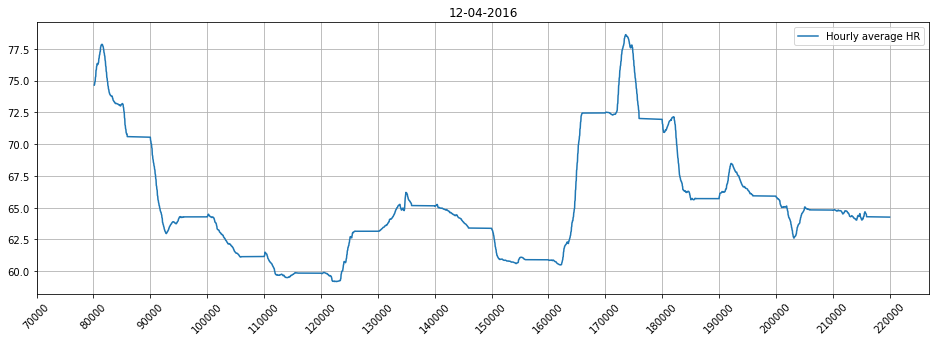

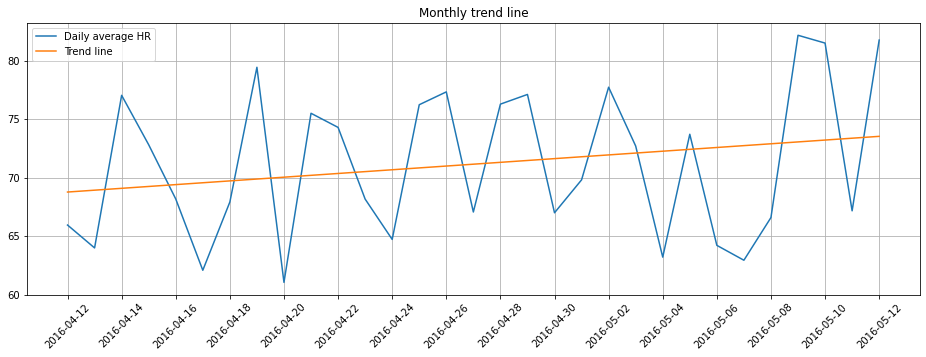

There is an upward trend.


In [8]:
test = heart_rate_plots.loc[(heart_rate_plots.Time.dt.year == 2016) & (heart_rate_plots.Time.dt.month == 4) & 
                            (heart_rate_plots.Time.dt.day == 12)]
test = test.set_index(test.Time.dt.time)
test['intTime'] = test.Time.dt.time.astype(str).str.replace(":", "").astype(int)

# plot figure
plt.figure(figsize = (16, 5))
plt.title('12-04-2016')

plt.plot(test.intTime, test.Value.rolling(440).mean(), label = 'Hourly average HR') 
plt.xticks([x for x in range(70000, 220001, 10000)], rotation = 45)

plt.legend()
plt.grid()
plt.show()

print('\n')

# monthly trend line
rijst = heart_rate_plots.copy()
rijst['date'] = rijst.Time.dt.date

df_plot = pd.DataFrame(rijst.groupby('date').Value.mean())
old = df_plot.index

# need ordinal index for regression
df_plot.index = df.index.map(dt.date.toordinal)

slope, intercept, r_value, p_value, std_error = linregress(df_plot.index, df_plot.Value)

# build trend line
x_endpoints = pd.DataFrame([df_plot.index[0], df_plot.index[-1]])
y_endpoints = intercept + slope * x_endpoints

# reset index for the right xticks
df_plot.index = old

# plot figure 
plt.figure(figsize = (16, 5))
plt.title('Monthly trend line')

plt.plot(df_plot.index, df_plot, label = 'Daily average HR')
plt.plot([dt.date.fromordinal(i[0]) for i in x_endpoints.values], y_endpoints.values, label = 'Trend line')

plt.xticks(df.index[0::2], rotation = 45)

plt.grid()
plt.legend()
plt.show()

if slope > 0:
    print('There is an upward trend.')
elif slope < 0:
    print('There is a downward trend')
else:
    print('Wtf is happening?')

# Decision tree